# Monte Carlo Simulation of Temperature for Weather Derivative Pricing

Github: https://github.com/TheQuantPy/youtube-tutorials/blob/8e64e19629cee840928b51baf4660e5c777e87e7/2022/003%20Jul-Sep/2022-08-31%20Monte%20Carlo%20Simulation%20of%20Temperature%20for%20Weather%20Derivative%20Pricing.ipynb

Simulating paths from out modified Ornstein-Uhlenbeck Process

## Quick Summary on Temperature Modelling
NOTE: Everything we have done so far in this series has been under the Physical probability measure P, including for our parameter estimation of the following models.

In [2]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import interpolate

import matplotlib.pyplot as plt

max_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/maximum_temperature.csv')
min_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/minimum_temperature.csv')

def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on=['Date'])

def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

temps['T'] = temps.apply(avg_temp,axis=1)

# drop na values here
temps = temps.dropna()

temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

temp_t.head()

,T
Date,
1859-01-01,19.45
1859-01-02,20.05
1859-01-03,19.75
1859-01-04,21.05
1859-01-05,20.75


# Modified mean-reverting Ornstein-Uhlenbeck (OU) process


<AxesSubplot:xlabel='Date'>

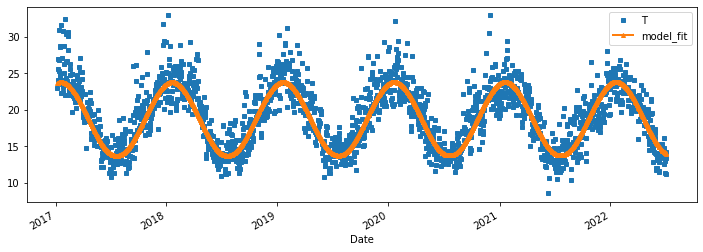

In [3]:
if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)

def T_model(x, a, b, alpha, theta):
    omega = 2*np.pi/365.25
    T = a + b*x + alpha*np.sin(omega*x + theta)
    return T

def dT_model(x, a, b, alpha, theta):
    omega=2*np.pi/365.25
    dT =  b + alpha*omega*np.cos(omega*x + theta)
    return dT

Tbar_params = [16.8, 3.32e-05, 5.05, 1.27]

temp_t['model_fit'] = T_model(temp_t.index-first_ord, *Tbar_params)

if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)

temp_t[-2000:].plot(figsize=(12,4), style=['s','^-','k--'] , markersize=4, linewidth=2 )

# Volatility of Temperature Process

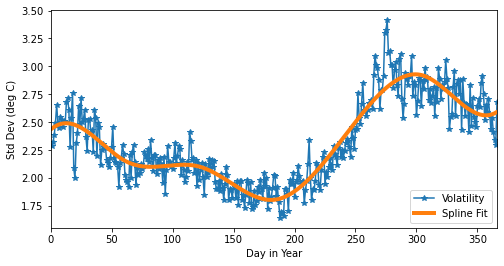

In [4]:
temp_vol = temps['T'].copy(deep=True)
temp_vol = temp_vol.to_frame()
temp_vol['day'] = temp_vol.index.dayofyear
temp_vol['month'] = temp_vol.index.month

vol = temp_vol.groupby(['day'])['T'].agg(['mean','std'])
days = np.array(vol['std'].index)
T_std = np.array(vol['std'].values)

def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    t, c, k = interpolate.splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

volatility = spline(5, days, T_std)
plt.figure(figsize=(8,4))
plt.plot(days, T_std, marker='*',label='Volatility')
plt.plot(days, volatility, linewidth=4, label='Spline Fit')
plt.ylabel('Std Dev (deg C)')
plt.xlabel('Day in Year')
plt.xlim(0,366)
plt.legend(loc='lower right')
plt.show()

# Simulating Paths


In [6]:
def euler_step(row, kappa, M):
    """Function for euler scheme approximation step in
    modified OH dynamics for temperature simulations
    Inputs:
    - dataframe row with columns: T, Tbar, dTbar and vol
    - kappa: rate of mean reversion
    Output:
    - temp: simulated next day temperatures
    """
    if row['Tbar_shift'] != np.nan:
        T_i = row['Tbar']
    else:
        T_i = row['Tbar_shift']
    T_det = T_i + row['dTbar']
    T_mrev =  kappa*(row['Tbar'] - T_i)
    sigma = row['vol']*np.random.randn(M)
    return T_det + T_mrev + sigma

def monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, M=1, kappa=0.438):
    """Monte Carlo simulation of temperature
    Inputs:
    - trading_dates: pandas DatetimeIndex from start to end dates
    - M: number of simulations
    - Tbar_params: parameters used for Tbar model
    - vol_model: fitted volatility model with days in year index
    - first_ord: first ordinal of fitted Tbar model
    Outputs:
    - mc_temps: DataFrame of all components individual components
    - mc_sims: DataFrame of all simulated temerpature paths
    """
    if isinstance(trading_dates, pd.DatetimeIndex):
        trading_date=trading_dates.map(dt.datetime.toordinal)

    # Use Modified Ornstein-Uhlenbeck process with estimated parameters to simulate Tbar DAT
    Tbars = T_model(trading_date-first_ord, *Tbar_params)

    # Use derivative of modified OH process SDE to calculate change of Tbar
    dTbars = dT_model(trading_date-first_ord, *Tbar_params)

    # Create DateFrame with thi
    mc_temps = pd.DataFrame(data=np.array([Tbars, dTbars]).T,
                            index=trading_dates, columns=['Tbar','dTbar'])

    # Create columns for day in year
    mc_temps['day'] = mc_temps.index.dayofyear

    # Apply BSpline volatility model depending on day of year
    mc_temps['vol'] = vol_model[mc_temps['day']-1]

    # Shift Tbar by one day (lagged Tbar series)
    mc_temps['Tbar_shift'] = mc_temps['Tbar'].shift(1)

    # Apply Euler Step Pandas Function
    data = mc_temps.apply(euler_step, args=[kappa, M], axis=1)

    # Create final DataFrame of all simulations
    mc_sims = pd.DataFrame(data=[x for x in [y for y in data.values]],
                 index=trading_dates,columns=range(1,M+1))

    return mc_temps, mc_sims

# Simulation of Temperature

In [7]:
# define trading date range
no_sims = 5
trading_dates = pd.date_range(start='2022-09-01', end='2025-08-31', freq='D')
mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord, no_sims)

### MC_Temps DataFrame


In [8]:
mc_temps

,Tbar,dTbar,day,vol,Tbar_shift
2022-09-01,15.004367,0.057635,244,2.415893,NaN
2022-09-02,15.062558,0.058745,245,2.430148,15.004367
2022-09-03,15.121850,0.059837,246,2.444373,15.062558
2022-09-04,15.182227,0.060912,247,2.458559,15.121850
2022-09-05,15.243669,0.061969,248,2.472699,15.182227
...,...,...,...,...,...
2025-08-27,14.779898,0.052135,239,2.344455,14.728364
2025-08-28,14.832628,0.053323,240,2.358738,14.779898
2025-08-29,14.886538,0.054495,241,2.373031,14.832628
2025-08-30,14.941613,0.055651,242,2.387327,14.886538


### MC_Sims DataFrame

In [9]:
mc_sims


,1,2,3,4,5
2022-09-01,13.909260,11.087786,15.285019,14.810661,19.618057
2022-09-02,18.007463,13.658527,15.321780,9.267428,14.647976
2022-09-03,17.333437,16.056914,12.113298,17.172478,11.895330
2022-09-04,14.970515,14.183129,16.354257,17.411495,15.403719
2022-09-05,11.984464,11.986926,16.856504,15.193431,14.426812
...,...,...,...,...,...
2025-08-27,15.078351,18.328027,15.264905,13.928093,14.754649
2025-08-28,13.939542,14.176807,13.769693,15.751899,17.396363
2025-08-29,15.124905,14.147501,16.283288,14.164238,14.674481
2025-08-30,16.324330,14.476585,17.979328,17.472364,13.046516


### Plot an Individual Simulation


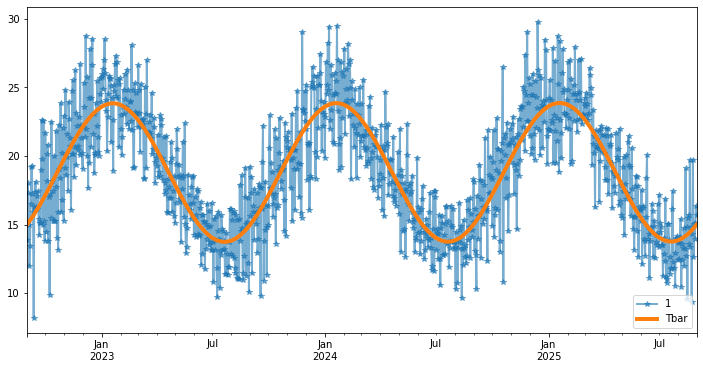

In [10]:
plt.figure(figsize=(12,6))
mc_sims[1].plot(alpha=0.6,linewidth=2, marker='*')
mc_temps["Tbar"].plot(linewidth=4)
plt.legend(loc='lower right')
plt.show()

## Temperature distributions


In [11]:
no_sims = 10000
trading_dates_winter = pd.date_range(start='2023-07-01', end='2023-07-01', freq='D')
mc_temps_winter, mc_sims_winter = monte_carlo_temp(trading_dates_winter, Tbar_params, volatility, first_ord, no_sims)

trading_dates_summer = pd.date_range(start='2023-01-01', end='2023-01-01', freq='D')
mc_temps_summer, mc_sims_summer = monte_carlo_temp(trading_dates_summer, Tbar_params, volatility, first_ord, no_sims)


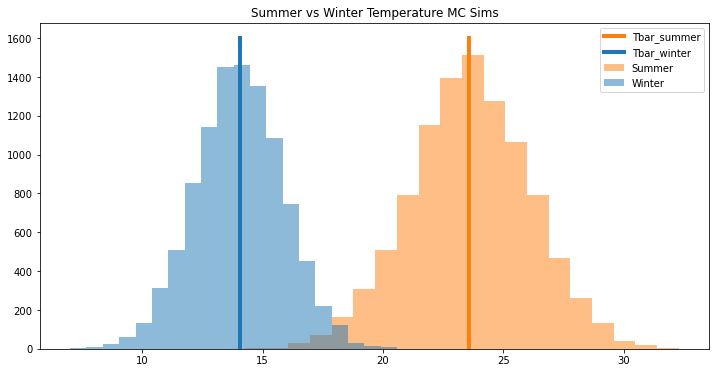

In [12]:
plt.figure(figsize=(12,6))
plt.title('Winter vs Summer Temperature MC Sims')

Tbar_summer = mc_temps_summer.iloc[-1,:]['Tbar']
Tbar_winter = mc_temps_winter.iloc[-1,:]['Tbar']

plt.hist(mc_sims_summer.iloc[-1,:],bins=20, alpha=0.5, label='Summer', color='tab:orange')
plt.plot([Tbar_summer,Tbar_summer],[0,1600], linewidth=4, label='Tbar_summer', color='tab:orange')
plt.title('Summer vs Winter Temperature MC Sims')

plt.hist(mc_sims_winter.iloc[-1,:],bins=20, alpha=0.5, label='Winter', color='tab:blue')
plt.plot([Tbar_winter,Tbar_winter],[0,1600], linewidth=4, label='Tbar_winter', color='tab:blue')
plt.legend()
plt.show()